# Read Data and Setup Neural Net

In [2]:
import csv

from sklearn.neural_network import MLPRegressor

import numpy as np

from globus_setup import *

# CSV_NAME = "new_data.csv"
CSV_NAME = "values_normalized.csv"

print("reading data")
Xpred = []
X = []
y = []
with open(CSV_NAME, "r") as f:
    csv_reader = csv.DictReader(f)

    training_fields = set(csv_reader.fieldnames) - {"tas"}
    for row in csv_reader:
        # Remove rows which are missing values for any variable
        empty_fields = [f for f in row if row[f] == ""]
        if empty_fields:
            continue
        features = {k: float(v) for k, v in row.items() if k in training_fields}
        X.append(features)
        y.append(float(row["tas"]))


reading data


In [3]:
## Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
y_train = np.array(y_train, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
days_test = np.array([row["day"] for row in X_test], dtype=np.double)
days_train = np.array([row["day"] for row in X_train], dtype=np.double)
X_train = np.array([[v for k, v in row.items() if k != "day"] for row in X_train], dtype=np.double)
X_test = np.array([[v for k, v in row.items() if k != "day"] for row in X_test], dtype=np.double)


In [9]:
## Cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False).split(X, y)

# Train Neural Net

In [7]:

clf = MLPRegressor(verbose=True, hidden_layer_sizes=[20]*10, tol=1e-10)
clf.fit(X_train, y_train)

Iteration 1, loss = 0.03534886
Iteration 2, loss = 0.01682720
Iteration 3, loss = 0.00301734
Iteration 4, loss = 0.00201789
Iteration 5, loss = 0.00180100
Iteration 6, loss = 0.00168837
Iteration 7, loss = 0.00166177
Iteration 8, loss = 0.00165024
Iteration 9, loss = 0.00159942
Iteration 10, loss = 0.00160259
Iteration 11, loss = 0.00158569
Iteration 12, loss = 0.00155186
Iteration 13, loss = 0.00158151
Iteration 14, loss = 0.00151787
Iteration 15, loss = 0.00151809
Iteration 16, loss = 0.00149586
Iteration 17, loss = 0.00150137
Iteration 18, loss = 0.00149310
Iteration 19, loss = 0.00145670
Iteration 20, loss = 0.00145612
Iteration 21, loss = 0.00143269
Iteration 22, loss = 0.00145381
Iteration 23, loss = 0.00146873
Iteration 24, loss = 0.00143342
Iteration 25, loss = 0.00142540
Iteration 26, loss = 0.00150876
Iteration 27, loss = 0.00149196
Iteration 28, loss = 0.00143754
Iteration 29, loss = 0.00144802
Iteration 30, loss = 0.00145168
Iteration 31, loss = 0.00141604
Iteration 32, los

MLPRegressor(hidden_layer_sizes=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
             tol=1e-10, verbose=True)

In [10]:
## Save model
import pickle
with open("model_cleaned_20_20_20.p", "wb") as f:
    pickle.dump(clf, f)

In [36]:
## Load model
import pickle
with open("model_original_20_20_20.p", "rb") as f:
    clf = pickle.load(f)

# Predict

In [5]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

y_pred = clf.predict(X_test)
print("r2_score: ", r2_score(y_test, y_pred))
print("explained_variance_score: ", explained_variance_score(y_test, y_pred))
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))

r2_score:  0.9713614685678501
explained_variance_score:  0.9714881933279221
mean_squared_error:  0.0018149594051385485


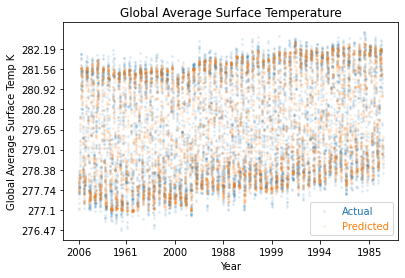

In [6]:
# Plot
from utilities import *

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(days_test, y_test, c='#1f77b4', s=3, alpha=.1, label='Actual')
xyears = np.array([int(get_date_from_offset(int(r), output_format="%Y")) for r in days_test])
xticks = np.arange(0, len(days_test), step=365*3)
yticks = np.arange(np.min(y_test), np.max(y_test), step=0.1)
ytemps = [round(unnormalize(yt), 2) for yt in yticks]
plt.xticks(np.sort(days_test)[xticks], xyears[xticks])
plt.yticks(yticks, ytemps)

## Trend line
# z = np.polyfit(days_test, y_test, 1)
# p = np.poly1d(z)
# ax.plot(days_test,p(days_test),"r--")

ax.scatter(days_test, y_pred, s=3, alpha=.1, c='#ff7f0e', label='Predicted')
ax.legend(labelcolor=('#1f77b4', '#ff7f0e'))

plt.title("Global Average Surface Temperature")
plt.ylabel("Global Average Surface Temp K")
plt.xlabel("Year")
fig.canvas.draw()
fig.canvas.flush_events()